### LAB<sup>9-3</sup> 성능 좋은 CNN을 가져다 써보자 (p.342)

**실습 목표**

텐서플로우는 이미 많은 학자들과 개발자들이 개발하여 검증한 훌륭한 CNN 모델을 제공하고 있다. 우리는 구글사에서 만든 inception V3라는 뛰어난 모델을 사용하여 MNIST 데이터의 분류를 할 것이다. 결과는 99%의 매우 높은 정확도를 보일 것이다.

#### 1. 텐서플로우와 맷플롯립, 넘파이, skimage등 관련 패키지를 임포트한다.

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from skimage.transform import resize
from keras.applications.inception_v3 import preprocess_input
from keras.applications.inception_v3 import InceptionV3
from keras import models, layers
from keras.models import Model, load_model
import pandas as pd
from tensorflow.keras.optimizers import RMSprop

#### 2. MNIST 데이터 셋을 읽고 학습용 데이터와 테스트용 데이터로 나누도록 하자.

8장에서 살펴본 바와 같이 학습에 사용할 데이터는 x_train이며, 이 데이터의 레이블이 y_train이다. 또한 테스트용 데이터 역시 데이터와 레이블로 이루어져 있다. 이 데이터들을 255로 나누어서 학습에 용이한 0에서 1 사이의 값으로 정규화시키는 것 역시 8장의 내용과 동일하다. 데이터가 너무 많아 빠른 실습을 위해 훈련 데이터는 10,000개, 검증 데이터는 2,000개만 사용해 보자.

In [ ]:
mnist = tf.keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()
# 훈련 데이터는 10000개, 검증 데이터는 2000개만 사용
x_train, x_test = x_train[:10000] / 255.0, x_test[:2000] / 255.0
y_train, y_test = y_train[:10000], y_test[:2000]

11501568/11490434 [==============================] - 0s 0us/step


#### 3. MNIST 데이터 셋의 이미지는 28x28 크기의 비교적 작은 이미지이다. 하지만 inception V3의 최소 입력 크기는 75x75 크기의 이미지이므로 x_train과 x_test의 모든 이미지 집합을 75x75 크기의 이미지로 변환시키는 전처리 과정이 필요하다. 또한 numpy의 dstack을 사용해서 빨강, 녹색, 파랑 채널을 동일한 색으로 지정하도록 한다.

In [ ]:
x_train_preprocess = np.zeros((x_train.shape[0], 75, 75, 3), dtype=np.float32)

print(x_train_preprocess.shape)
# 훈련 데이터 각각의 크기를 75x75로 변형 (인셉션 모델 최소 입력 크기)
for i, img in enumerate(x_train):
    img_resize = resize(img, (75, 75), anti_aliasing=True)
    x_train_preprocess[i] = np.dstack([img_resize, img_resize, img_resize])

(10000, 75, 75, 3)


#### 4. 테스트 데이터에도 같은 작업을 진행한다.

In [ ]:
x_test_preprocess = np.zeros((x_test.shape[0], 75, 75, 3), dtype=np.float32)

print(x_test_preprocess.shape)
# 훈련 데이터 각각의 크기를 75x75로 변형 (인셉션 모델 최소 입력 크기)
for i, img in enumerate(x_test):
    img_resize = resize(img, (75, 75), anti_aliasing=True)
    x_test_preprocess[i] = np.dstack([img_resize, img_resize, img_resize])

(2000, 75, 75, 3)


#### 5. 이제 다음과 같이 사전학습된 InceptionV3 모델을 가져오도록 하자.

이 모델의 입력은 (75, 75, 3)의 크기를 가지는 이미지 데이터가 될 것이다. include_top은 네트워크의 마지막 계층으로 맨 위에 완전 연결 계층을 포함할지 여부를 나타내는 bool값이며 이미 검증된 가중치를 사용할 경우 weights = 'imagenet'과 같은 가중치 값을 지정할 수 있다. 여기서는 None을 지정하여 임의의 난수값으로 가중치를 초기화한다. 생성된 모델의 정보를 summary()를 이용하여 살펴보면 이 모델에 사용된 많은 합성곱, 풀링층에 대한 정보를 볼 수 있다.

In [ ]:
pre_trained_model = InceptionV3(input_shape=(75, 75, 3),
                                include_top=False,
                                weights=None)
pre_trained_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 75, 75, 3)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 37, 37, 32)   864         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 37, 37, 32)  96          ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                                  
 activation (Activation)        (None, 37, 37, 32)   0           ['batch_normalization[

#### 6. 이제 Inception V3 모델을 어디까지 사용할 것인지 결정해야 한다. 

모델의 구조를 살펴보고 'mixed7'까지 사용하기로 결정했다고 하자. 그러면 마지막 계층을 얻어온다. 그리고 이 계층의 출력을 펼쳐서 입력으로 하는 레이어를 시작으로 몇 개의 층을 만든다. 이 층들을 케라스의 함수형 모델 API를 이용하여 만들자. 이 함수형 모델은 입력 신호를 생성하는 계층을 새로운 계층에 연결해 만드는데, 최종적으로 우리의 분류 목적에 맞게 10개의 출력을 가지도록 만들었다. 이 계층들을 x 변수에 담았다.

In [ ]:
# last_layer  = pre_trained_model.get_layer('mixed7')
last_layer  = pre_trained_model.get_layer('mixed10')
last_output = last_layer.output

x = layers.Flatten()(last_output)
# x = layers.Dense(1024, activation='relu')(x)
# x = layers.Dense(10, activation='sigmoid')(x)
x = layers.Dense(1024, activation='relu')(x)
x = layers.Dense(512, activation='relu')(x)
x = layers.Dense(10, activation='softmax')(x)

#### 7. 이제 Inception V3 모델의 일부와 새로운 계층들을 연결해 우리의 모델을 만들어야 한다. 이것은 케라스의 Model을 생성하면서 둘을 나열하면 된다. 모델을 만들고 컴파일한다.

In [ ]:
model = Model(pre_trained_model.input, x)

model.compile(optimizer=RMSprop(lr=0.001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


#### 8. 다음으로 에폭을 20으로 하고 모델을 학습시키도록 한다. 

신경망의 층도 많고 학습할 파라미터가 많기 때문에 첫 에폭을 시작하기 전에 매우 오랜 시간이 걸리며, 매 에폭마다 소요되는 학습 시간도 길다. 하지만 참고 기다리면 특징을 잘 찾아내는 합성곱 신경망 모델갑게 훈련 데이터에 대해 99%를 넘는 매우 높은 정확도를 가지는 분류기를 얻을 수 잇다. 데이터의 수를 줄여서 학습을 진행했기 때문에 과적합의 위험이 존재한다. 실제로 학습 중반까지는 검증 데이터에 대한 정확도가 매우 불안정할 수도 잇다. 그러나 학습 후반부에는 상당한 수준으로 높아질 것이다. 데이터 수를 늘려서 학습하면 과적합의 위험을 피할 수 있겠지만 학습에 걸리는 시간이 그 만큼 늘어날 것이다.

In [ ]:
history = model.fit(x_train_preprocess, y_train, epochs=20,
                    validation_data=(x_test_preprocess, y_test), verbose=0)

#### 9. 훈련 과정에서 모델이 보인 예측 정확도와 손실 값을 확인하기 위해 값들을 얻자.

In [ ]:
acc     = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss    = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

#### 10. 훈련 과정의 정확도와 손실을 화면에 그려서 확인해 보자.

테스트 데이터에 대해서도 99.4% 수준의 높은 정확도로 예측이 가능한 좋은 모델이 만들어졌다.

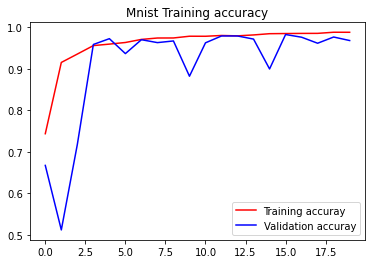

<Figure size 432x288 with 0 Axes>

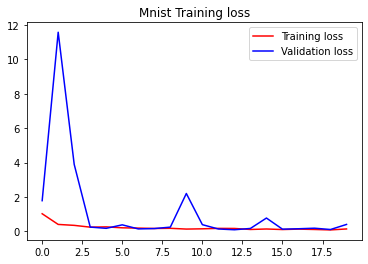

<Figure size 432x288 with 0 Axes>

In [ ]:
plt.plot(epochs, acc, 'r', label='Training accuray')
plt.plot(epochs, val_acc, 'b', label='Validation accuray')
plt.title("Mnist Training accuracy")
plt.legend(loc=0)
plt.figure()
plt.show()

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title("Mnist Training loss")
plt.legend(loc=0)
plt.figure()
plt.show()

그런데, 이 실습에서 몇 가지 문제를 발견할 수 있다. 우선은 매우 복잡한 모델이기 때문에 새로 훈련시키는 데에 너무 오랜 시간이 걸린다. 그리고 이미 방대한 양의 데이터로 Inception V3를 학습시켜 놓았는데, 가중치를 난수로 초기화하고 전체를 새로 학습하고 있다. 이것은 이전의 학습을 활용하지 못 하는 것이다. 이러한 문제를 개선하기 위해 **전이학습**<sup>transfer learning</sup>이라는 개념을 사용할 수 있다.